In [1]:
# We import numpy and the functions from the python scripts of main_functions_convnets and main_functions_classicNN.
import numpy as np
from main_functions_convnets import *
from main_functions_classicNN import *

In [2]:
def padding(X, pad=0):
    """ A function which pads a tensor of dimension 4, being (m, height, width, number_channels) the form of the 
    tensor. I want to pad along the axis of height and width. """
    
    X_pad = np.pad(X,((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values=0)
    
    return X_pad

pad= 1
X = np.ones([3,2,2,3])
X_pad = padding(X)

In [3]:
def convolution(A_prev_sample, kernel, stride=1, padding='valid'):
    """A function that implements a convolution of a sample of the dataset for one filter."""
    
    #First we calculate what is the height and width of the input. We consider that the input is given by the shape
    # (height, width, depth)
    height_input, width_input, depth = A_prev_sample.shape
    
    #Now we calculate f from the kernel. The kernel (o filter) is given with dimensions (f,f, number of channels)
    f, _, kernel_depth = kernel.shape
    
    # The padding is valid if we don't fill the image with 0's on its borders to manipulate dimensions.

    if padding == 'valid':
        pad = 0
    # If the padding is same it means I am calculating a pad so the input is the same as the output.    
    elif padding == 'same':
        pad = int((f-1)/2)
    
    # Here we calculate the shape of the output and we creatr
    
    height_output, width_output = int((height_input + 2*pad - f)/stride + 1), int((width_input + 2*pad - f)/stride + 1)
    # I create the output of the convolution after having considered f, the stride and the padding.
    conv_output = np.zeros([height_output, width_output])
    
    
    # Now we go in a for loop going through columns and the going down
    
    for height in range(height_output):
        # Now we go through the columns
        for width in range(width_output):
            
            #The current portion of the convolution will be image[height:(height+f), width:(width+f), :]
            current_portion = A_prev_sample[(height*stride):(height*stride+f), (width*stride):(width*stride+f),:]
            
            #Now I do the convolution operation throughout the whole input calling the function from the
            # main_functions_conv script.
            conv_output[height, width] = basic_convolution(current_portion, kernel)
                                         
    return conv_output
    

In [4]:
# Let's make a function that makes the convolution operation in a layer on all the filters and all the samples.
def convolution_forward(A_prev, W, stride=1, padding='valid'):
    """A function that takes the m samples of A_prev, all the filters from W and does an iteration in one
    layer of a convolution network."""
    
    # First we calculate the dimensions of A_prev --> (m, n_H_prev, n_W_prev, n_c_prev)
    m, n_H_prev, n_W_prev, n_C_prev_A_prev = A_prev.shape
    
    # Now we calculate the dimensions of the filters W --> (f, f, n_c_prev, n_c)
    f, _, n_C_prev_W, n_C = W.shape
    
    #If the padding is valid, then the pad is equals to 0.
    if padding == 'valid':
        pad = 0
    
    # Now we assert that the number of channels of A n_c_prev and of filters are the same.
    assert (n_C_prev_A_prev == n_C_prev_W), "The number of channels of the previous layer must be the same\
    in the kernels as well as in the activation A_prev."
    
    # Now we calculate the height and width of the output.
    
    n_H, n_W = int((n_H_prev + 2*pad - f)/stride + 1),\
        int((n_W_prev + 2*pad - f)/stride + 1)
     
    # We now have the dimensions of the output. I will call it Z.
    Z = np.zeros([m, n_H, n_W, n_C])
    
    # Now we go through the m samples and the number of channels n_C in the layer:
    for i in range(m):
        # We go to the i sample of the dataset
        A_prev_sample = A_prev[i]
        
        for c in range(n_C):
            # Now let's get each of the filters of the network and apply the convolution. We have to slice the
            # last dimension so we get the kernel of dimensions (f,f, n_C). This is W[:,:,:,c]
            kernel = W[:,:,:,c]
            # Once we get the kernel of channel c we can do the convolution to the sample and we can insert it
            # in the i'th sample of the network in the channel c.
            Z[i,:,:,c] = convolution(A_prev_sample, kernel, stride, padding)
            
    #Once convolution is made through the m samples and the n_C channels we have obtained the convolution in that 
    # layer and we can return Z.
    
    return Z
    

In [5]:
# Now we create a function that adds the bias to the output we got from the convolution making broascast with numpy.
# This allows us to add to the 4D array of dimensions (number_samples, n_height, n_width, number of channels)
# a 2D array of dimensions (1, number of channels) to add the bias along the axis of the channels.

def add_bias(conv_output, biases):
    """A function that adds the bias to each of the outputs we get from each filter applied.
    The biases of a convolutional layer has shape (1, number of filters)"""
    # First, we make sure that the number of biases applied to the output conv_output is the same as the number of channels
    # (The last dimension of conv_output). We consider that we are getting as input a 4D array of shape (m, n_H, n_W, n_C).
    # We first assert that.
    n_dim_conv_output = len(conv_output.shape)
    n_dim_b = len(biases.shape)
    assert(n_dim_conv_output == 4 and n_dim_b == 2), "The number of dimensions of conv_output must be 4 and the number of dimensions \
    of b must be 2."
    
    _, _ , _, n_C_conv_output = conv_output.shape
    _, n_C_b = biases.shape
    
    assert(n_C_conv_output == n_C_b), "The number of biases must be the same as the number of channels of conv_output."
    
    conv_output_with_bias = conv_output + biases
    
    return conv_output_with_bias
    

In [6]:
def activation_convolution(A_prev, W, biases, activation_name='relu', stride=1, padding='valid'):
    """A function that makes all the operations involved in a convolutional layer. This is applying all the
    convolution filters given by the 4D array W, adding the bias to the 4D array obtained, and finally
    applying an activation function. The dimensions given must be the following:
    A_prev ---> (number_samples, height, width, number_channels_prev)
    W ---> (f, f, number_channels_prev, number_filters) being f the height and width of the filters 
    applied (Considering that width=height) 
    biases ---> (1, number_filters)"""
    
    # We first make sure that the dimensions given are appropiate: 
    # A_prev is a 4D array of shape :(m, n_H_prev, n_W_prev, n_channels_prev)
    # W is a 4D array with all the filters in that layer and shape : (f, f, n_channels_prev, n_channels)
    # biases is a 2D array of shape : (1, n_channels)
    assert (len(A_prev.shape) == 4 and len(W.shape) == 4 and len(biases.shape) == 2), "The dimensions must be :\
    A_prev a 4D array with shape (number_samples, height, width, number_channels_prev) ; W a 4D array with shape \
    (f, f, number_channels_prev, number_filters) and b a 2D array with shape (1, number_filters)"
    
    # First we apply the convolution with the function convolution_forward
    conv_output = convolution_forward(A_prev, W, stride, padding)
    # Next we add the bias the the convolution output
    Z = add_bias(conv_output, biases)
    
    # Finally we apply the activation function with the function activation_functions that we have in the 
    # main_functions_classicNN
    A = activation_functions(Z, activation_name)
    
    # Finally we return the output of the convolution after adding the bias and activation obtained A after 
    # applying the activation function ('By default is the relu').
    return Z, A

In [20]:
# Starting the operations of max pooling and average pooling on one channel.
def pooling_sample(A_prev_sample, f, pooling_type='max', stride=1):
    """A function  that makes the pooling operation for one sample. By default it makes the max pooling operation."""
    #As we have one sample, we have a 3D array with shape (n_H_prev, n_W_prev, n_C_prev). We can assert this
    # to make sure we give the right arguments.
    assert (len(A_prev_sample.shape) == 3), "The A_prev_sample must be a 3D array"
    
    n_H_prev, n_W_prev, n_C_prev = A_prev_sample.shape
    
    # Now we get the dimensions obtained with the f and stride:
    n_H = get_n_H(n_H_prev, f, stride)
    n_W = get_n_W(n_W_prev, f, stride)

    # Now we can create the output of the sample with dimensions height, width and the number of channels are the
    # same as in the input given.
    
    Z_sample = np.zeros([n_H, n_W, n_C_prev])
    
    # And now we can operate through the sample
    for c in range(n_C_prev):
        # We get the slice of A_prev in the channel c, so we are getting the matrix of channel c (2D-array)
        A_sample_channel = A_prev_sample[:,:,c]
        
        # Now we have the 2D array of channel c we can iterate over the height and the width of the matrix.
        for h in range(n_H):
            for w in range(n_W):
                # Now we need to iterate through the matrix in the channel c considering the stride and f:
                current_portion = A_sample_channel[(h*stride):(h*stride+f),\
                                                   (w*stride):(w*stride+f)]
                
                # Now we can extract the max or the mean of that portion depending if we want to do a max-pooling
                # or average pooling.
                if pooling_type.lower() == 'max':
                    Z_sample[h, w, c] = np.max(current_portion)
                elif pooling_type.lower() == 'average':
                    Z_sample[h, w, c] = np.mean(current_portion)
    
    # Once done in all the channels, we can return Z_sample
    return Z_sample
                
    

In [21]:
# Now we need to develop the function that makes the pooling through all the samples. In this case we receive
# as input a 4D array with dimensions (m, n_H_prev, n_W_prev, n_C_prev). We make as default stride=1 and the 
# pooling type max_pooling. In the pooling layers it is never used the padding because the main goal of this 
# operation is to reduce the dimensions of the input.

def pooling_forward(A_prev, f, pooling_type='max', stride=1):
    """A function that makes the pooling operation for all the samples of that layer"""
    
    # Let's assert the dimensions of A_prev as a 4D-array with shape (m, n_H_prev, n_W_prev, n_C_prev)
    assert (len(A_prev.shape) == 4), "A_prev must be a 4D-array with shape (m, n_H_prev, n_W_prev, n_C_prev)"
    
    # Now we get the dimensions of A_prev.
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    
    #Let's get the dimensions of n_H and n_W considering f and the stride.
    n_H = get_n_H(n_H_prev, f, stride)
    n_W = get_n_W(n_W_prev, f, stride)
    
    # Now we can create the output
    Z = np.zeros([m, n_H, n_W, n_C_prev])
    
    
    # After having the dimensions, we can go in a for loop for the m samples and use the last function 
    # pooling_sample that makes the pooling for one sample.
    
    for i in range(m):
        
        # We consider the sample i from A_prev
        A_prev_sample = A_prev[i]
        #Once we have the sample i we can use the function pooling_sample
        Z[i] = pooling_sample(A_prev_sample, f, pooling_type, stride)
    return Z    

In [22]:
# A function that flattens the first fully connected layer. It makes it by reshaping it into a matrix of shape
# (m, number_features), being the number of features the product of n_H, n_W and n_C
def fully_connected(A):
    """Reshaping the 4D array into a 2D array with shape (m, n_H*n_W*n_C)"""
    m = A.shape[0]
    features = np.prod(A.shape[1:])
    A_FC = A.reshape((m,-1), order='A').T
    
    return A_FC

In [29]:
def get_shape_network(X_shape, network_structure):
    """A function that gets the dimensions of the whole network. """
    m, n_H_prev, n_W_prev, n_C_prev = X_shape
    shape_network = {'layer_0': X_shape}
    
    # I am going to iterate over the network_structure dictionary, getting ix as the number of layer we are
    # and layer as the key.
    for ix,layer in enumerate(network_structure):
        # We first fetch the dictionary from the current layer, which provides information about being a
        # convolutional layer, a layer to flatten or a fully connected layer.
        info_layer = network_structure[layer]
        
        # If the current layer is a convolution, we get the dimensions obtained in the convolution
        if 'conv' in info_layer:
            
            # Now we fetch the dictionary that is going to provide us the parameters of the conv layer:
            conv_info = info_layer['conv']
            
            # Once we get conv_info, we can get the parameters needed f, the stride, the type of padding and
            # the number of filters applied.
            f_conv = conv_info['f']
            stride_conv = conv_info['stride']
            padding_conv = conv_info['padding']
            number_filters = conv_info['number_filters']
            
            n_H = get_n_H(n_H_prev, f_conv, stride_conv, padding_conv)
            n_W = get_n_W(n_W_prev, f_conv, stride_conv, padding_conv)
            
            # Once we have n_H and n_W we can add to the shape_network dictionary the info needed to know the shape
            # of this conv layer.
            shape_network['layer_' + str(ix+1)] = {'conv': (m, n_H, n_W, number_filters)}
            
            # Now we check if there is pooling in this layer. The value of pooling will be a value of True or
            # False
            pooling = info_layer['pool_present']
            
            # If the pooling is false we do not consider parameters of pooling, and we get the values of Z_conv
            # and A_conv as the cache in that layer
            if pooling is False:
                shape_network['layer_' + str(ix+1)]['pool_present'] = False
                
                # We also update the n_H_prev and n_W_prev now because there is no pooling in this layer.
                n_H_prev = n_H
                n_W_prev = n_W
                
            # If there is pooling we get the parameters of the pooling, we pool A_conv and we save the cache.
            elif pooling is True:
                
                shape_network['layer_' + str(ix+1)]['pool_present'] = True
                
                # If the pooling is True, then we get the info of pool
                pool_info = info_layer['pool']
                
                # Now we get the info we need from the dictionary to get the shape of the layer. 
                # Note: To get the shape of the network we only need f and stride, not the pooling type.
                f_pool = pool_info['f']
                stride_pool = pool_info['stride']
                
                # We also need to update n_H_prev and n_W_prev from the convolution.
                n_H_prev = n_H
                n_W_prev = n_W
                
                # We now get n_H and n_W from the pooling. Padding is not used in pooling parts.
                n_H = get_n_H(n_H_prev, f_pool, stride_pool)
                n_W = get_n_W(n_W_prev, f_pool, stride_pool)
                
                # Now we can give the information about the pooling:
                shape_network['layer_' + str(ix+1)]['pool'] = (m, n_H, n_W, number_filters)
                
                # Now we can update the parameters n_W_prev and n_H_prev
                
                n_H_prev = n_H
                n_W_prev = n_W
                
        elif 'flatten' in info_layer:
            shape_network['layer_' + str(ix+1)] = {'flattened':(m, n_H_prev*n_W_prev*number_filters)}
            
            
        elif 'fully_connected' in info_layer:
            fc_info = info_layer['fully_connected']
            number_neurons = fc_info['number_neurons']
            
            # Beware that you are creating a new dictionary. You cannot assign directly keys to it before creating
            # it.
            shape_network['layer_' + str(ix+1)] = {'fully_connected':(m, number_neurons)}
            
            
    return shape_network
        
        

In [30]:
# Now a build the function with which I initiate the parameters from all the network.

def initiate_parameters(X_sample_shape, network_structure, neurons_flattened):
    """A function that starts randomly the values of the parameters in the Convolutional Network.
    It is consider that X_sample_shape is a 3D-array that represents an image.
    The network structure is a dictionary giving the information about the network. 
    
    Example:
    
    X_sample_shape ---> (n_H, n_W, number_channels)
    
    
    network_structure = {'layer_1':{'conv':{'f':5, 'stride':2, 'number_filters':10,\
                                        'padding':'valid', 'activation_name': 'relu'},\
                                'pool_present':True, 'pool':{'type':'max','f':2, 'stride':2}},\
                'layer_2':{'conv': {'f':4, 'stride':2, 'number_filters':20, 'padding':'valid'},\
                           'pool_present':True, 'pool':{'type':'max', 'f':2, 'stride':2}},\
                    'layer_3':{'flatten':{}},
                    'layer_4':{'fully_connected':{'number_neurons':84, 'activation_name':'relu'}},\
                     'layer_5':{'fully_connected':{'number_neurons':10, 'activation_name':'softmax'}}}
    
    neurons_flattened ---> the neurons that we get when we flatten a convolutional layer. It is an integer number
    """
    assert(len(X_sample_shape) == 3), "X_sample_shape should be a tuple which is giving the dimensions of a\
    3D array representing a single image of the input"
    
    # First, we extract from X_sample_shape the number of channels:
    _, _, number_channels_prev = X_sample_shape
    
    
    filters_dict = {}
    biases_conv_dict = {}
    weights_dict = {}
    biases_fc_dict = {}
    
    for ix, layer in enumerate(network_structure):
        # We extract the info of the layer:
        info_layer = network_structure[layer]
        
        if 'conv' in info_layer:
            # We extract the info from the convolutional layer
            conv_info = info_layer['conv']
            
            f = conv_info['f']
            number_channels = conv_info['number_filters']
            
            filters_dict['W_' + str(ix+1)] = np.random.randn(f, f, number_channels_prev, number_channels)*0.01
            biases_conv_dict['b_' + str(ix+1)] = np.random.randn(1, number_channels)
            
            # Now we can update the current number of channels as number_channels_prev
            number_channels_prev = number_channels
            
        elif 'flatten' in info_layer:
            number_neurons_prev = neurons_flattened
        
        elif 'fully_connected' in info_layer:
            # We first get the number of neurons of the current layer.
            fc_info = info_layer['fully_connected']
            number_neurons = fc_info['number_neurons']
            weights_dict['W_' + str(ix+1)] = np.random.randn(number_neurons, number_neurons_prev)*0.01
            biases_fc_dict['b_' + str(ix+1)] = np.random.randn(number_neurons, 1)*0.01
            
            # Now we can update the number of neurons in the current layer as number_neurons_prev
            number_neurons_prev = number_neurons
    
    return filters_dict, biases_conv_dict, weights_dict, biases_fc_dict

In [31]:
def represent_parameters(filters_dict, biases_conv_dict, weights_dict, biases_fc_dict):
    """A function that prints the structure of the weights and biases of the whole network."""
    # A function that prints the shape of the parameters in the whole network
    for key in filters_dict:
        print('filter {} with shape {}'.format(key,filters_dict[key].shape))
    
    for key in biases_conv_dict:
        print('convolutional bias {} with shape {}'.format(key, biases_conv_dict[key].shape))

    for key in weights_dict:
        print('weights {} with shape {}'.format(key,weights_dict[key].shape))
    
    for key in biases_fc_dict:
        print('fc_bias {} with shape {}'.format(key,biases_fc_dict[key].shape))
    

In [106]:

def forward_propagation_convnet(X, filters_dict, biases_conv_dict, weights_dict, biases_fc_dict,
                                network_structure):
    """A function that makes a forward iteration in the whole network, considering either convolutional
    layers or fully connected layers.
    X ---> The input that goes to the network with shape (m, n_H, n_W, number_channels)
    filters_dict --> A dictionary that contains all the filters from the convolutional layers.
    biases_conv_dict --> A dictionary that contains all the biases from the convolutional layers.
    weights_dict --> A dictionary that contains the weights from the fully connected layers (Classical layers
    of a Neural Network).
    Network_structure --> A dictionary that provides the information about the parameters in each of the layers
    of the network."""
    
    # Let's save the cache of A and Z obtained through the network.
    A_cache = {'A_0':X}
    Z_cache = {}
    
    # The first A_prev is from the input X
    A_prev = X
    
    # Now we iterate through the network with the function enumerate to get the index and keys of the network.
    for ix,layer in enumerate(network_structure):
        
        # We extract the info of the layer
        info_layer = network_structure[layer]
        
        # Let's check what kind of layer it is (convolutional, flattened layer or fully_connected)
        
        # The first option is the layer being convolutional (i.e. 'conv')
        if 'conv' in info_layer:
            
            W = filters_dict['W_' + str(ix+1)]
            biases = biases_conv_dict['b_' + str(ix+1)]
            
            conv_info = info_layer['conv']
            
            f = conv_info['f']
            stride = conv_info['stride']
            padding = conv_info['padding']
            activation_name = conv_info['activation_name']
            
            # Now we get the activation from the activation_convolution where we get both Z and A
            Z, A = activation_convolution(A_prev, W, biases, activation_name,\
                                   stride, padding)
            
            # Now we can save in the cache of the layer Z and A that come from the convolution and from the
            # activation.
            Z_cache['Z_conv_' + str(ix+1)] = Z
            A_cache['A_conv_' + str(ix+1)] = A
            
            A_prev = A
            
            
            pooling = info_layer['pool_present']
            
            # We consider that if there is pooling, it is always in a convolutional layer, so we get the value
            #(True or False) of the pooling.
            if pooling is False:
                # If the pooling is false we go to the next layer, so we break this iteration and we go to the
                # next layer.
                continue
                
            else:
                # As we are pooling in this layer we can extract the info from it
                pool_info = info_layer['pool']
                
                pool_type = pool_info['type']
                f_pool = pool_info['f']
                stride_pool = pool_info['stride']
                
                A_pooled = pooling_forward(A, f_pool, pool_type, stride_pool)
                
                A_cache['A_conv_' + str(ix+1) + '_pooled'] = A_pooled
                
                # We now need to update A_prev as Z_pool because it is the input the next layer has to receive.
                
                A_prev = A_pooled
            
        elif 'flatten' in info_layer:
            # We flatten the previous A. We don't need to get any info from this type of layer.
            A = fully_connected(A_prev)
            A_cache['A_flat_' + str(ix+1)] = A
            
            # Finally we can update A_prev as A.
            A_prev = A
        
            
        
        elif 'fully_connected' in info_layer:
            # We extract the info of this layer.
            fc_info = info_layer['fully_connected']
            
            # We get the number of neurons and the activation name in this layer
            activation_name = fc_info['activation_name']
            
            # We also get the weights and biases we need.
            W = weights_dict['W_' + str(ix+1)]
            biases = biases_fc_dict['b_' + str(ix+1)]
            
            
            Z, A = linear_and_forward_activation(W, A_prev, biases, activation_name)
            
            # Once we get the linear activation Z and the activation A we save those values in the cache.
            Z_cache['Z_FC_' + str(ix+1)] = Z
            A_cache['A_FC_' + str(ix+1)] = A
            
            # Now we can update Z_prev and A_prev
            A_prev = A
            
        else:
            raise Exception('Error about the name provided in the layer {}, the name of the layer must be either \
             conv, flatten or fully_connected.'.format(ix))
            
    
    # Once we have gone through the whole network, we can return the caches of Z and A.
    
    return Z_cache, A_cache        
           

In [107]:
def represent_A_Z_caches(A_cache, Z_cache):
    """A function that prints the structure of the weights and biases of the whole network."""
    # A function that prints the shape of the parameters in the whole network
    for key in A_cache.keys():
        print('A with name {} and shape={}'.format(key, A_cache[key].shape))
        
    for key in Z_cache.keys():
        print('Z with name {} and shape={}'.format(key, Z_cache[key].shape))    

## <div align="center"> <u> EXAMPLE OF NETWORK <u>    
### <div align="center"> I am going to use the example of the network at the bottom of this image. This notes are from Deep Learning Course from Andrew Ng.
    

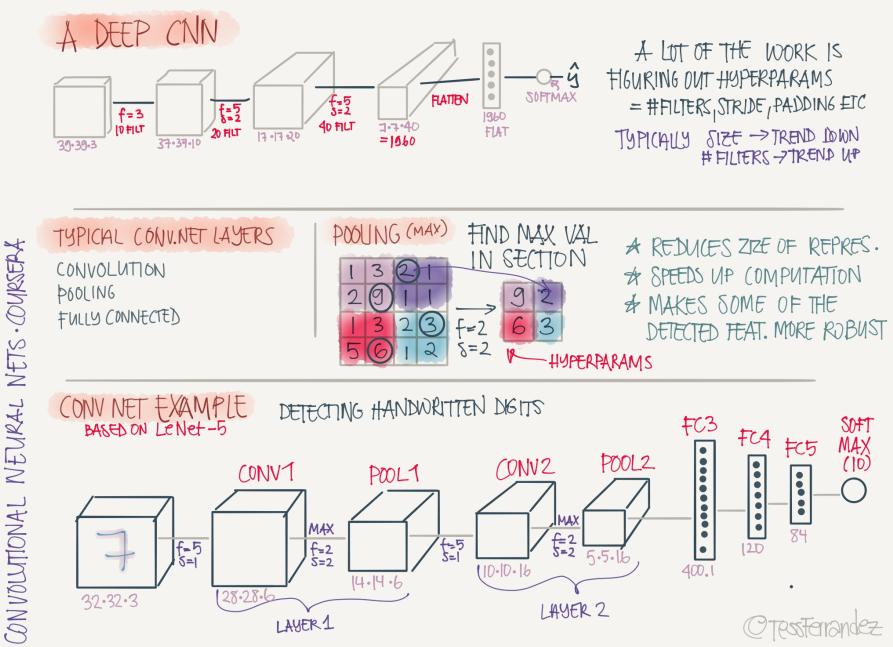

In [113]:
network_structure = {'layer_1':{'conv':{'f':5, 'stride':1, 'number_filters':6,\
                                        'padding':'valid', 'activation_name': 'relu'},\
                                'pool_present':True, 'pool':{'type':'max','f':2, 'stride':2}},\
                'layer_2':{'conv': {'f':5, 'stride':1, 'number_filters':16, 'padding':'valid',\
                                    'activation_name': 'relu'},\
                           'pool_present':True, 'pool':{'type':'max', 'f':2, 'stride':2}},\
                    'layer_3':{'flatten':{}},
                    'layer_4':{'fully_connected':{'number_neurons':120, 'activation_name':'relu'}},\
                     'layer_5':{'fully_connected':{'number_neurons':84, 'activation_name':'relu'}},\
                    'layer_6':{'fully_connected':{'number_neurons':10, 'activation_name': 'softmax'}}}



In [114]:
# Test box
np.random.seed(1)
n_H = 32
n_W = 32
n_C = 3
m = 50
X_shape = (m, n_H, n_W, n_C)
X = np.random.randn(*X_shape)
get_shape_network(X_shape, network_structure)

filters_dict, biases_conv_dict, weights_dict, biases_fc_dict = initiate_parameters(X_sample_shape=(n_H, n_H, n_C),\
                                                      network_structure=network_structure, neurons_flattened=400)

In [115]:
represent_parameters(filters_dict, biases_conv_dict, weights_dict, biases_fc_dict)

filter W_1 with shape (5, 5, 3, 6)
filter W_2 with shape (5, 5, 6, 16)
convolutional bias b_1 with shape (1, 6)
convolutional bias b_2 with shape (1, 16)
weights W_4 with shape (120, 400)
weights W_5 with shape (84, 120)
weights W_6 with shape (10, 84)
fc_bias b_4 with shape (120, 1)
fc_bias b_5 with shape (84, 1)
fc_bias b_6 with shape (10, 1)


In [116]:
Z_cache, A_cache = forward_propagation_convnet(X, filters_dict, biases_conv_dict, weights_dict, biases_fc_dict,
                                network_structure)

In [117]:
represent_A_Z_caches(A_cache=A_cache, Z_cache=Z_cache)

A with name A_0 and shape=(50, 32, 32, 3)
A with name A_conv_1 and shape=(50, 28, 28, 6)
A with name A_conv_1_pooled and shape=(50, 14, 14, 6)
A with name A_conv_2 and shape=(50, 10, 10, 16)
A with name A_conv_2_pooled and shape=(50, 5, 5, 16)
A with name A_flat_3 and shape=(400, 50)
A with name A_FC_4 and shape=(120, 50)
A with name A_FC_5 and shape=(84, 50)
A with name A_FC_6 and shape=(10, 50)
Z with name Z_conv_1 and shape=(50, 28, 28, 6)
Z with name Z_conv_2 and shape=(50, 10, 10, 16)
Z with name Z_FC_4 and shape=(120, 50)
Z with name Z_FC_5 and shape=(84, 50)
Z with name Z_FC_6 and shape=(10, 50)
